# Part I

## Question 1

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

#### Load the data (dimaond dataset)

In [2]:
raw_df = pd.read_csv("diamonds.csv")
raw_df = raw_df.drop(columns=["Unnamed: 0"])

#### numerical encoding for categorical features

In [3]:
cut_raw_to_num = {
    "Fair": 1,
    "Good": 2,
    "Very Good": 3,
    "Premium": 4,
    "Ideal": 5
}
color_raw_to_num = {
    "J": 1,
    "I": 2,
    "H": 3,
    "G": 4,
    "F": 5,
    "E": 6,
    "D": 7,
}
clarity_raw_to_num = {
    "I1": 1,
    "SI2": 2,
    "SI1": 3,
    "VS2": 4,
    "VS1": 5,
    "VVS2": 6,
    "VVS1": 7,
    "IF": 8
}
all_raw_to_num = {
    **cut_raw_to_num,
    **color_raw_to_num,
    **clarity_raw_to_num
}

In [4]:
df = raw_df.replace(all_raw_to_num)

### Question 1.1

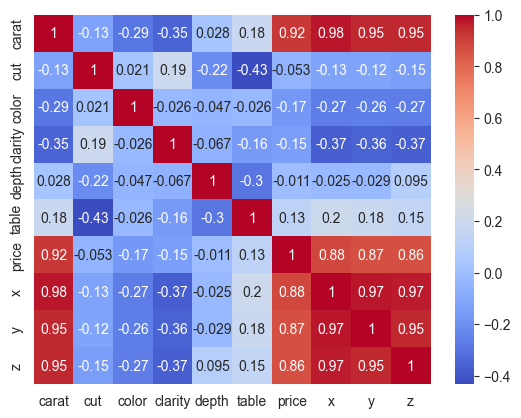

In [5]:
q1_1_corr = df.corr(method='pearson')
sns.heatmap(q1_1_corr, annot=True, cmap="coolwarm")
plt.show()

In [6]:
q1_1_highest = q1_1_corr['price'].abs().sort_values(ascending=False).index[1]
print("Feature with highest absolute correlation with the target variable: " + q1_1_highest)

Feature with highest absolute correlation with the target variable: carat


The correlation pattern suggests strong relationship between weight and size of a dimond and its price.

### Question 1.2

#### Plot of histogram of numerical features (originally)

In [7]:
q1_2_original_num_col = [
    "carat",
    "depth",
    "table",
    "x",
    "y",
    "z"
]

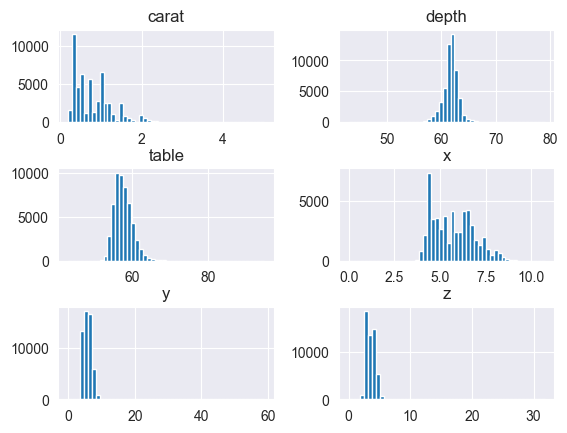

In [8]:
df[q1_2_original_num_col].hist(bins=50)
plt.subplots_adjust(hspace=0.5) 
plt.show()

#### Plot of histogram of numerical features (categorical features converted)

In [9]:
q1_2_categorical_num_col = [
    "cut",
    "color",
    "clarity"
]

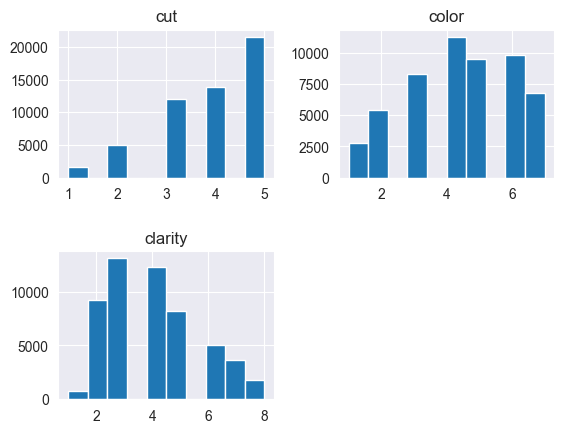

In [10]:
df[q1_2_categorical_num_col].hist()
plt.subplots_adjust(hspace=0.5) 
plt.show()

If the distribution of a feature has high skewness, we can perform:
- square root transformation: take the square root for each value in the feature, this only applies to non negative values which fits our dataset greatly if there is high skewness.

### Question 1.3

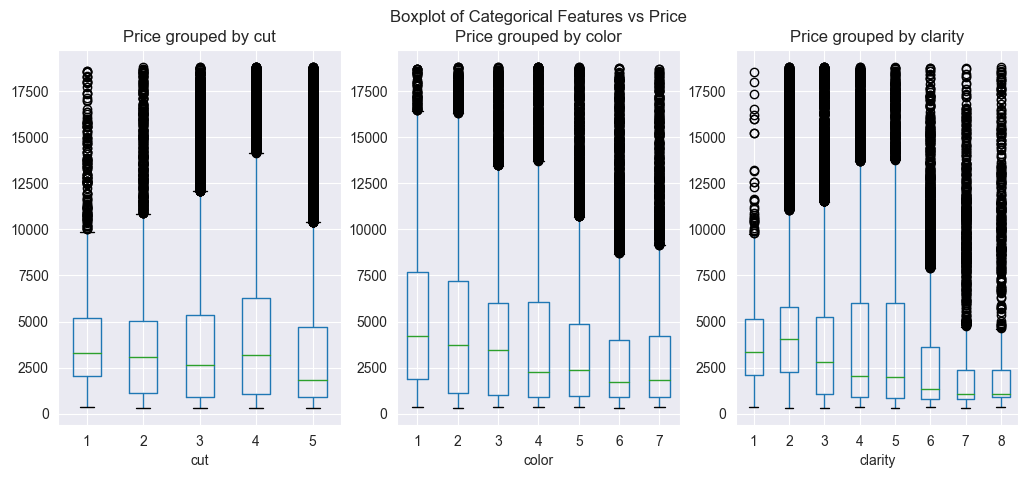

In [11]:
q1_3_cat_col = [
    "cut",
    "color",
    "clarity"
]
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
for i in range(len(q1_3_cat_col)):
    fet_name = q1_3_cat_col[i]
    df[[fet_name, "price"]].boxplot(by=[fet_name], ax=ax[i])
    ax[i].title.set_text('Price grouped by ' + fet_name)
    ax[i].set_xlabel(fet_name)

fig.suptitle('Boxplot of Categorical Features vs Price')
plt.show()

As we can see from the boxplots above, it's counter intuitive that as cut/color/clarity increases in the better direction, the price actually decreases, however, one important fact is the target feature is price not unit price. We will show later that as three features grows in better direction, the unit price actually increases as we'd expected.

### Question 1.4

#### Plot of counts by color, cut, clarity with original labels

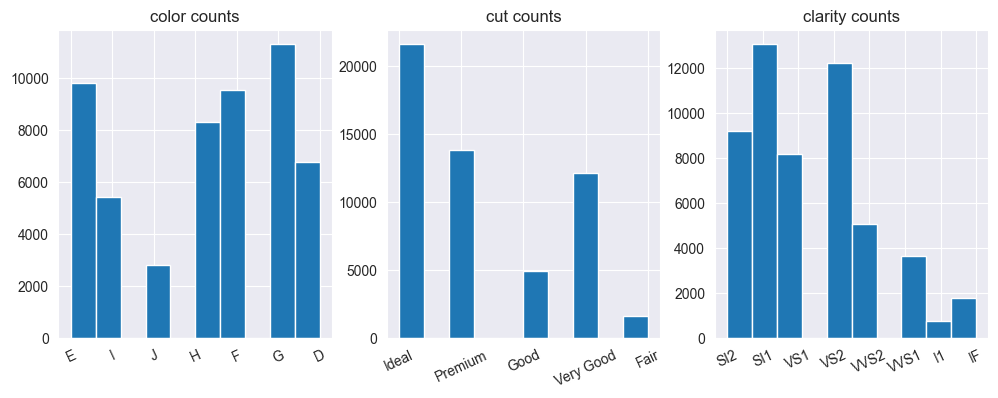

In [12]:
q1_4_cols = ["color", "cut", "clarity"]
fig, ax = plt.subplots(1, len(q1_4_cols), figsize=(12, 4))

for i in range(len(q1_4_cols)):
    raw_df[q1_4_cols[i]].hist(ax=ax[i])
    ax[i].title.set_text(q1_4_cols[i] + " counts")
    ax[i].tick_params("x", labelrotation=25)
    
plt.show()

## Question 2

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression

### Question 2.1

In [14]:
q2_1_scaler = StandardScaler()
df[q1_2_original_num_col] = q2_1_scaler.fit_transform(df[q1_2_original_num_col])
df[q1_2_categorical_num_col] = q2_1_scaler.fit_transform(df[q1_2_categorical_num_col])

### Question 2.2

#### Mutual Information

In [15]:
q2_2_mut_res = mutual_info_regression(df[q1_2_original_num_col + q1_2_categorical_num_col], df["price"])

In [16]:
pd.DataFrame(list(zip(q1_2_original_num_col + q1_2_categorical_num_col, q2_2_mut_res)),
             columns=["Feature", "Estimated Mutual Information"]).set_index("Feature")

,Estimated Mutual Information
Feature,
carat,1.654712
depth,0.030515
table,0.034466
x,1.411353
y,1.421282
z,1.361244
cut,0.057779
color,0.138986
clarity,0.217804


#### F Score

In [17]:
q2_2_f_score, _ = f_regression(df[q1_2_original_num_col + q1_2_categorical_num_col], df["price"])

In [18]:
pd.DataFrame(list(zip(q1_2_original_num_col + q1_2_categorical_num_col, q2_2_f_score)),
             columns=["Feature", "F Score"]).set_index("Feature")

,F Score
Feature,
carat,304051.486619
depth,6.115863
table,886.119363
x,193741.523066
y,160915.662263
z,154923.266553
cut,154.784468
color,1654.401244
clarity,1188.007065


#### List two features for either dataset that has the lowest MI w.r.t to the target.

Depth and table are the two features that have the lowest MI w.r.t. the target.

#### Describe how this step qualitatively affects the performance of your models in terms of test RMSE. Is it true for all model types?
This step is crucial because it affects the performance of all our models. If we select features that are not significant in predicting the price of a diamond, we may not get an as accurate prediction, while using a lot of computation power. If we select the right number of features andd take into consideration which ones are most important, we should be able to train a model with a low rmse. This is only true for regression models. The two lowest mutual information scores are the two variables depth and table.

# Question 3 

#### Explain what OOB error and $R^2$ score means for random forest model.
In a random forest, there are bootstrapped samples of the training set, and with this, there some rows of the training set that are left out of particular decision trees. The OOB score is the number of correctly predicted rows that were left out of the bag. There are many advantages of the OOB score, for instance, it has less variance and requires less computing power. 

The $R^2$ metric is a value between 0 and 1 that determines where the model is a good fit for the data, i.e how much of the data's variance can it explain.

When evaluating a random forest model, the OOB score is often more accurate and more useful. 

## Training and Testing of Different Models

In [19]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.neural_network import MLPRegressor

In [20]:
feat_cols = q1_2_original_num_col + q1_2_categorical_num_col

##########HERE CHANGE
feat_cols = ['carat', 'depth', 'x', 'cut', 'color', 'clarity']

targ_col = "price"
kfold = KFold(n_splits=10)

In [21]:
def do_model(model, param_grid={}, df=df, verbose=0):
    grid = GridSearchCV(
        model,
        param_grid,
        cv=10,
        scoring="neg_root_mean_squared_error",
        return_train_score=True,
        n_jobs=-1,
        verbose=verbose)
    grid = grid.fit(df[feat_cols], df[targ_col])
    grid.avg_train_rmse = list(map(lambda x: -x, grid.cv_results_["mean_train_score"]))
    grid.avg_test_rmse = list(map(lambda x: -x, grid.cv_results_["mean_test_score"]))
    return grid

### Linear Regression

#### Ordinary Least Squares regression

In [22]:
ols = do_model(LinearRegression())

#### Lasso regression

In [23]:
lasso = do_model(Lasso())

#### Ridge regression

In [24]:
ridge = do_model(Ridge())

### Question 4.1

In [25]:
pd.DataFrame({
    "Feature": feat_cols,
    "OLS": ols.best_estimator_.coef_,
    "Lasso": lasso.best_estimator_.coef_,
    "Ridge": ridge.best_estimator_.coef_
}).set_index("Feature")

,OLS,Lasso,Ridge
Feature,,,
carat,5085.348104,5039.562081,5082.899769
depth,-92.337499,-89.174239,-92.209558
x,-954.649062,-909.594286,-952.252907
cut,164.609641,163.834461,164.602501
color,549.355914,547.353154,549.286561
clarity,830.255965,830.169575,830.276261


Based on the above data, the absolute value of all coefficients are low for Lasso (L1) regression. It remains similar for Ridge (L2) regression compared with OLS.

### Question 4.2

In [26]:
q4_2_reg_mult = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]
q4_2_ols = do_model(LinearRegression())
q4_2_lasso = do_model(Lasso(), {"alpha": q4_2_reg_mult})
q4_2_ridge = do_model(Ridge(), {"alpha": q4_2_reg_mult})

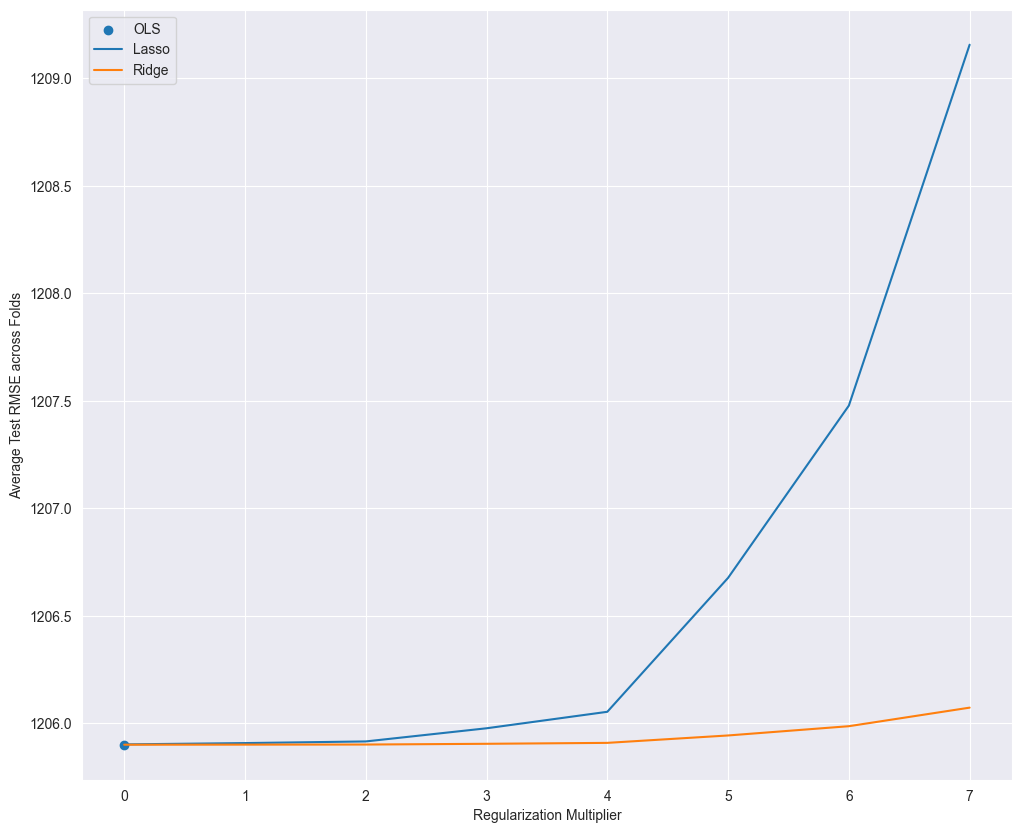

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))

ax.scatter(0, q4_2_ols.avg_test_rmse[0], label="OLS")
x = range(len(q4_2_reg_mult))
ax.plot(x, q4_2_lasso.avg_test_rmse, label="Lasso")
ax.plot(x, q4_2_ridge.avg_test_rmse, label="Ridge")

plt.xlabel("Regularization Multiplier")
plt.ylabel("Average Test RMSE across Folds")

plt.legend()
plt.show()

As we can see in the graph, regularization only increase the RMSE, so the best regularization scheme is no regularization.

### Question 4.3

In [28]:
non_stand_df = raw_df.replace(all_raw_to_num)

In [29]:
q4_3_alpha_list = list(map(lambda x: 0.1*x, range(21)))
q4_3_non_stand_models = do_model(Ridge(), {"alpha": q4_3_alpha_list}, df=non_stand_df)
q4_3_stand_models = do_model(Ridge(), {"alpha": q4_3_alpha_list}, df=df)

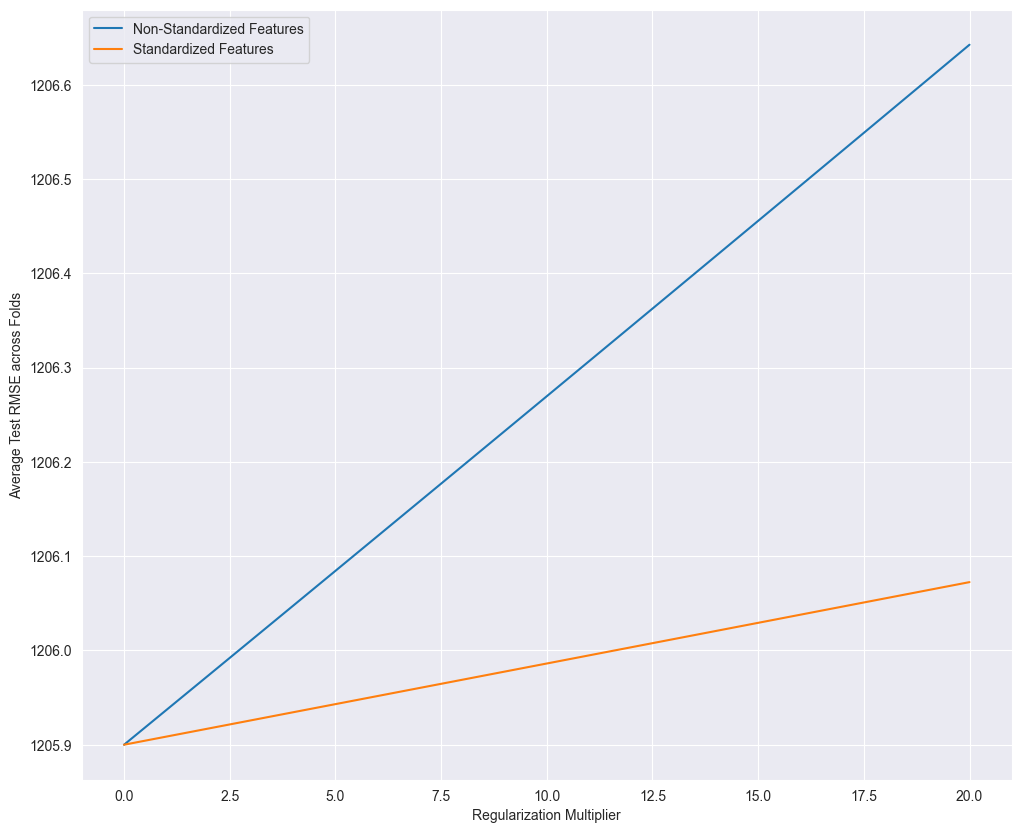

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))

x = range(21)
ax.plot(x, q4_3_non_stand_models.avg_test_rmse, label="Non-Standardized Features")
ax.plot(x, q4_3_stand_models.avg_test_rmse, label="Standardized Features")

plt.xlabel("Regularization Multiplier")
plt.ylabel("Average Test RMSE across Folds")

plt.legend()
plt.show()

Feature standardization helps performance, but really minor. As we can see in the above plot.

### Question 4.4

The p-value is the probability of observing a value that is equal to 0, in other words, whether a specific feature will add information into our model, significant or not. To determine the most significant features, we can use a threshold for the p-vale and whether it is below a threshold, then the probability of it being 0, is very low. 

In [31]:
import itertools
from sklearn.model_selection import GridSearchCV
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

## Polynomial Regression

### Question 5.1

In [32]:
pipe = Pipeline([
    ("poly", PolynomialFeatures()),
    ("ridge", Ridge())
])

param = {
    "poly__degree": [1, 2, 3, 4, 5, 6]
}

In [33]:
grid = GridSearchCV(pipe, param_grid = param, cv = 10, n_jobs = -1, 
                    scoring = 'neg_root_mean_squared_error')
X = df[feat_cols]
y = df[targ_col]
grid.fit(X, y)

df_rdg = pd.DataFrame({"Best Polynomial Regression": [grid.best_estimator_, 
                                                      grid.best_params_, 
                                                      np.sqrt(-1 * grid.best_score_)]})
df_rdg.index = ["Best Estimator", "Best Parameters", "RMSE"]
df_rdg

,Best Polynomial Regression
Best Estimator,"(PolynomialFeatures(degree=3), Ridge())"
Best Parameters,{'poly__degree': 3}
RMSE,25.719061


The top 5 most salient features from the features that we had picked out turned out to be clarity, x, carat, cut, and color.

The reason is that the most important factor for determining a diamond's price is its size.

### Question 5.2

We used a grid search with a 10-fold cross validation across varying degress from 1 to 6. We found that the best degree was 3. If the degree on the training set is very high, it is very susceptible to overfitting because it is adding more features and making the model more complex. We see that the mean test RMSE score is 25.498

### Neural Network

### Question 6.1

##### Identity function as output layer activation function

In [34]:
mlp = MLPRegressor(max_iter = 1000, verbose = False)
hidden_layer_sizes = [50, 100, 150]
layer_sizes = []
for i in range(1, len(hidden_layer_sizes) + 1):
    for subset in itertools.combinations_with_replacement(hidden_layer_sizes, i):
        layer_sizes += [subset]
        
param = {"hidden_layer_sizes": [50, 100, 150], 
         "alpha": [0.0001, 0.001, 0.01]}

X = df[feat_cols]
y = df[targ_col]
grid_mlp = GridSearchCV(estimator = mlp, 
                        param_grid = param, 
                        cv = 5, 
                        scoring = "neg_mean_squared_error", 
                        n_jobs = -1)
grid_mlp.fit(X, y)
df_mlp = pd.DataFrame({"Best MLP": [grid_mlp.best_estimator_, 
                                    grid_mlp.best_params_, 
                                    np.sqrt(-1 * grid_mlp.best_score_)]})
df_mlp.index = ["Best Estimator", "Best Parameters", "RMSE"]
df_mlp

C:\ProgramData\Anaconda3\envs\cs269\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


,Best MLP
Best Estimator,"MLPRegressor(hidden_layer_sizes=150, max_iter=..."
Best Parameters,"{'alpha': 0.0001, 'hidden_layer_sizes': 150}"
RMSE,1219.600341


In [35]:
best_mlp = do_model(grid_mlp.best_estimator_)
print("Average Train RMSE:", best_mlp.avg_train_rmse)
print("Average Test RMSE:", best_mlp.avg_test_rmse)

Average Train RMSE: [596.5570480609418]
Average Test RMSE: [587.7981988702339]


C:\ProgramData\Anaconda3\envs\cs269\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


##### ReLu function as output layer activation function

In [70]:
mlp_relu = MLPRegressor(max_iter = 1000, verbose = False)
mlp_relu.out_activation = "relu"
hidden_layer_sizes = [50, 100, 150]
layer_sizes = []
for i in range(1, len(hidden_layer_sizes) + 1):
    for subset in itertools.combinations_with_replacement(hidden_layer_sizes, i):
        layer_sizes += [subset]
        
param = {"hidden_layer_sizes": [50, 100, 150], 
         "alpha": [0.0001, 0.001, 0.01]}

X = df[feat_cols]
y = df[targ_col]
grid_mlp_relu = GridSearchCV(estimator = mlp_relu, 
                             param_grid = param, 
                             cv = 5, 
                             scoring = "neg_mean_squared_error", 
                             n_jobs = -1)
grid_mlp_relu.fit(X, y)
df_mlp_relu = pd.DataFrame({"Best MLP": [grid_mlp_relu.best_estimator_, 
                                    grid_mlp_relu.best_params_, 
                                    np.sqrt(-1 * grid_mlp_relu.best_score_)]})
df_mlp_relu.index = ["Best Estimator", "Best Parameters", "RMSE"]
df_mlp_relu

C:\ProgramData\Anaconda3\envs\cs269\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


,Best MLP
Best Estimator,"MLPRegressor(hidden_layer_sizes=100, max_iter=..."
Best Parameters,"{'alpha': 0.0001, 'hidden_layer_sizes': 100}"
RMSE,1233.537242


In [71]:
best_mlp_relu = do_model(grid_mlp_relu.best_estimator_)
print("Average Train RMSE:", best_mlp_relu.avg_train_rmse)
print("Average Test RMSE:", best_mlp_relu.avg_test_rmse)

Average Train RMSE: [621.9418749114471]
Average Test RMSE: [606.1763925613068]


C:\ProgramData\Anaconda3\envs\cs269\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [40]:
import statsmodels.regression.linear_model as sm

## Question 6.2 Linear Regression 

In [41]:
avg_rmse_ols = []
for train_idxs, test_idxs in kfold.split(df):
        train = df.iloc[train_idxs]
        train_x = train[feat_cols]
        train_y = train[targ_col]
        test = df.iloc[test_idxs]
        test_x = test[feat_cols]
        test_y = test[targ_col]

        lin_reg = sm.OLS(endog = train_y, exog = train_x)
        lis_reg_res = lin_reg.fit()
        ypred = lis_reg_res.predict(test_x)
        avg_rmse_ols.append(mean_squared_error(test_y, ypred, squared = False))

df_ols = pd.DataFrame({"OLS": [np.mean(avg_rmse_ols)]})
df_ols.index = ["Average RMSE"]
df_ols

,OLS
Average RMSE,4646.330484


## 6.3
We decided to use the ReLu activation function because other activation functions typ-
ically run into the Vanishing Gradient problem where neuron outputs are fairly small and
hence as we advance layers, the values will become smaller and smaller, leading to a very
slow convergence to their optimum value. ReLu on the other hand, the maximum threshold
is infinity and hence will not have consecutive small neuron outputs, avoiding the Vanishing
Gradient Problem.

## 6.4
Increasing the depth of a neural network runs the risk of overtraining the model. If the problem at hand is not very complex, the addition of hidden layers will begin to identify the individual differences between the data, being unable to generalize the results, leading to a possibly higher training accuracy with a significant lower testing accuracy. Besides overfitting, the it will take longer for the model to train, even on the training data, because as the neural network becomes deeper, during back-propagation, the gradients need to be passed through too many layers and becomes super close to 0, making it hard for earlier layers to learn.

## 7.1

Maximum Number of Features: 
    - May increase the accuracy because it gives more options to the nodes in the forest; however, it decreases the diversity in each tree, and hence may, in turn, decrease the accuracy

Number of Trees:
    - Higher number of trees allows the regression to be more accurate but will also increase computation power and decrease the speed
    
Depth of each tree:
    - The larger the depth of a tree in a forest means the more the tree is able to split and capture the differences in the entire dataset, however, too much depth may lead to overfitting

## 7.2

Random forests use nested if-else statements to draw the boundaries between the data. By using these if-else statements, it draws partial rectangles between the data and hence these rectangles are of varying sizes, being able to capture non-linearity within the dataset. 

## 7.3

In [42]:
from sklearn.ensemble import RandomForestRegressor
import random
from sklearn import tree

In [43]:
rf = RandomForestRegressor(oob_score = True)
param = {"max_depth": [1, 2, 3, 4], "max_features": [i for i in range(1, len(feat_cols) + 1)]}
grid_rf = GridSearchCV(estimator = rf, param_grid = param, cv = 10, scoring = "neg_mean_squared_error", n_jobs = -1)
X = df[feat_cols]
y = df[targ_col]
grid_rf.fit(X, y)

GridSearchCV(cv=10, estimator=RandomForestRegressor(oob_score=True), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'max_features': [1, 2, 3, 4, 5, 6]},
             scoring='neg_mean_squared_error')

In [44]:
df_rf = pd.DataFrame({"Best Random Forest": [grid_rf.best_estimator_, 
                                             grid_rf.best_params_, 
                                             np.sqrt(-1 * grid_rf.best_score_), 
                                             grid_rf.best_estimator_.oob_score_]})
df_rf.index = ["Best Estimator", "Best Parameters", "RMSE", "OOB Score"]
df_rf

,Best Random Forest
Best Estimator,"(DecisionTreeRegressor(max_depth=4, max_featur..."
Best Parameters,"{'max_depth': 4, 'max_features': 3}"
RMSE,1605.763539
OOB Score,0.927344


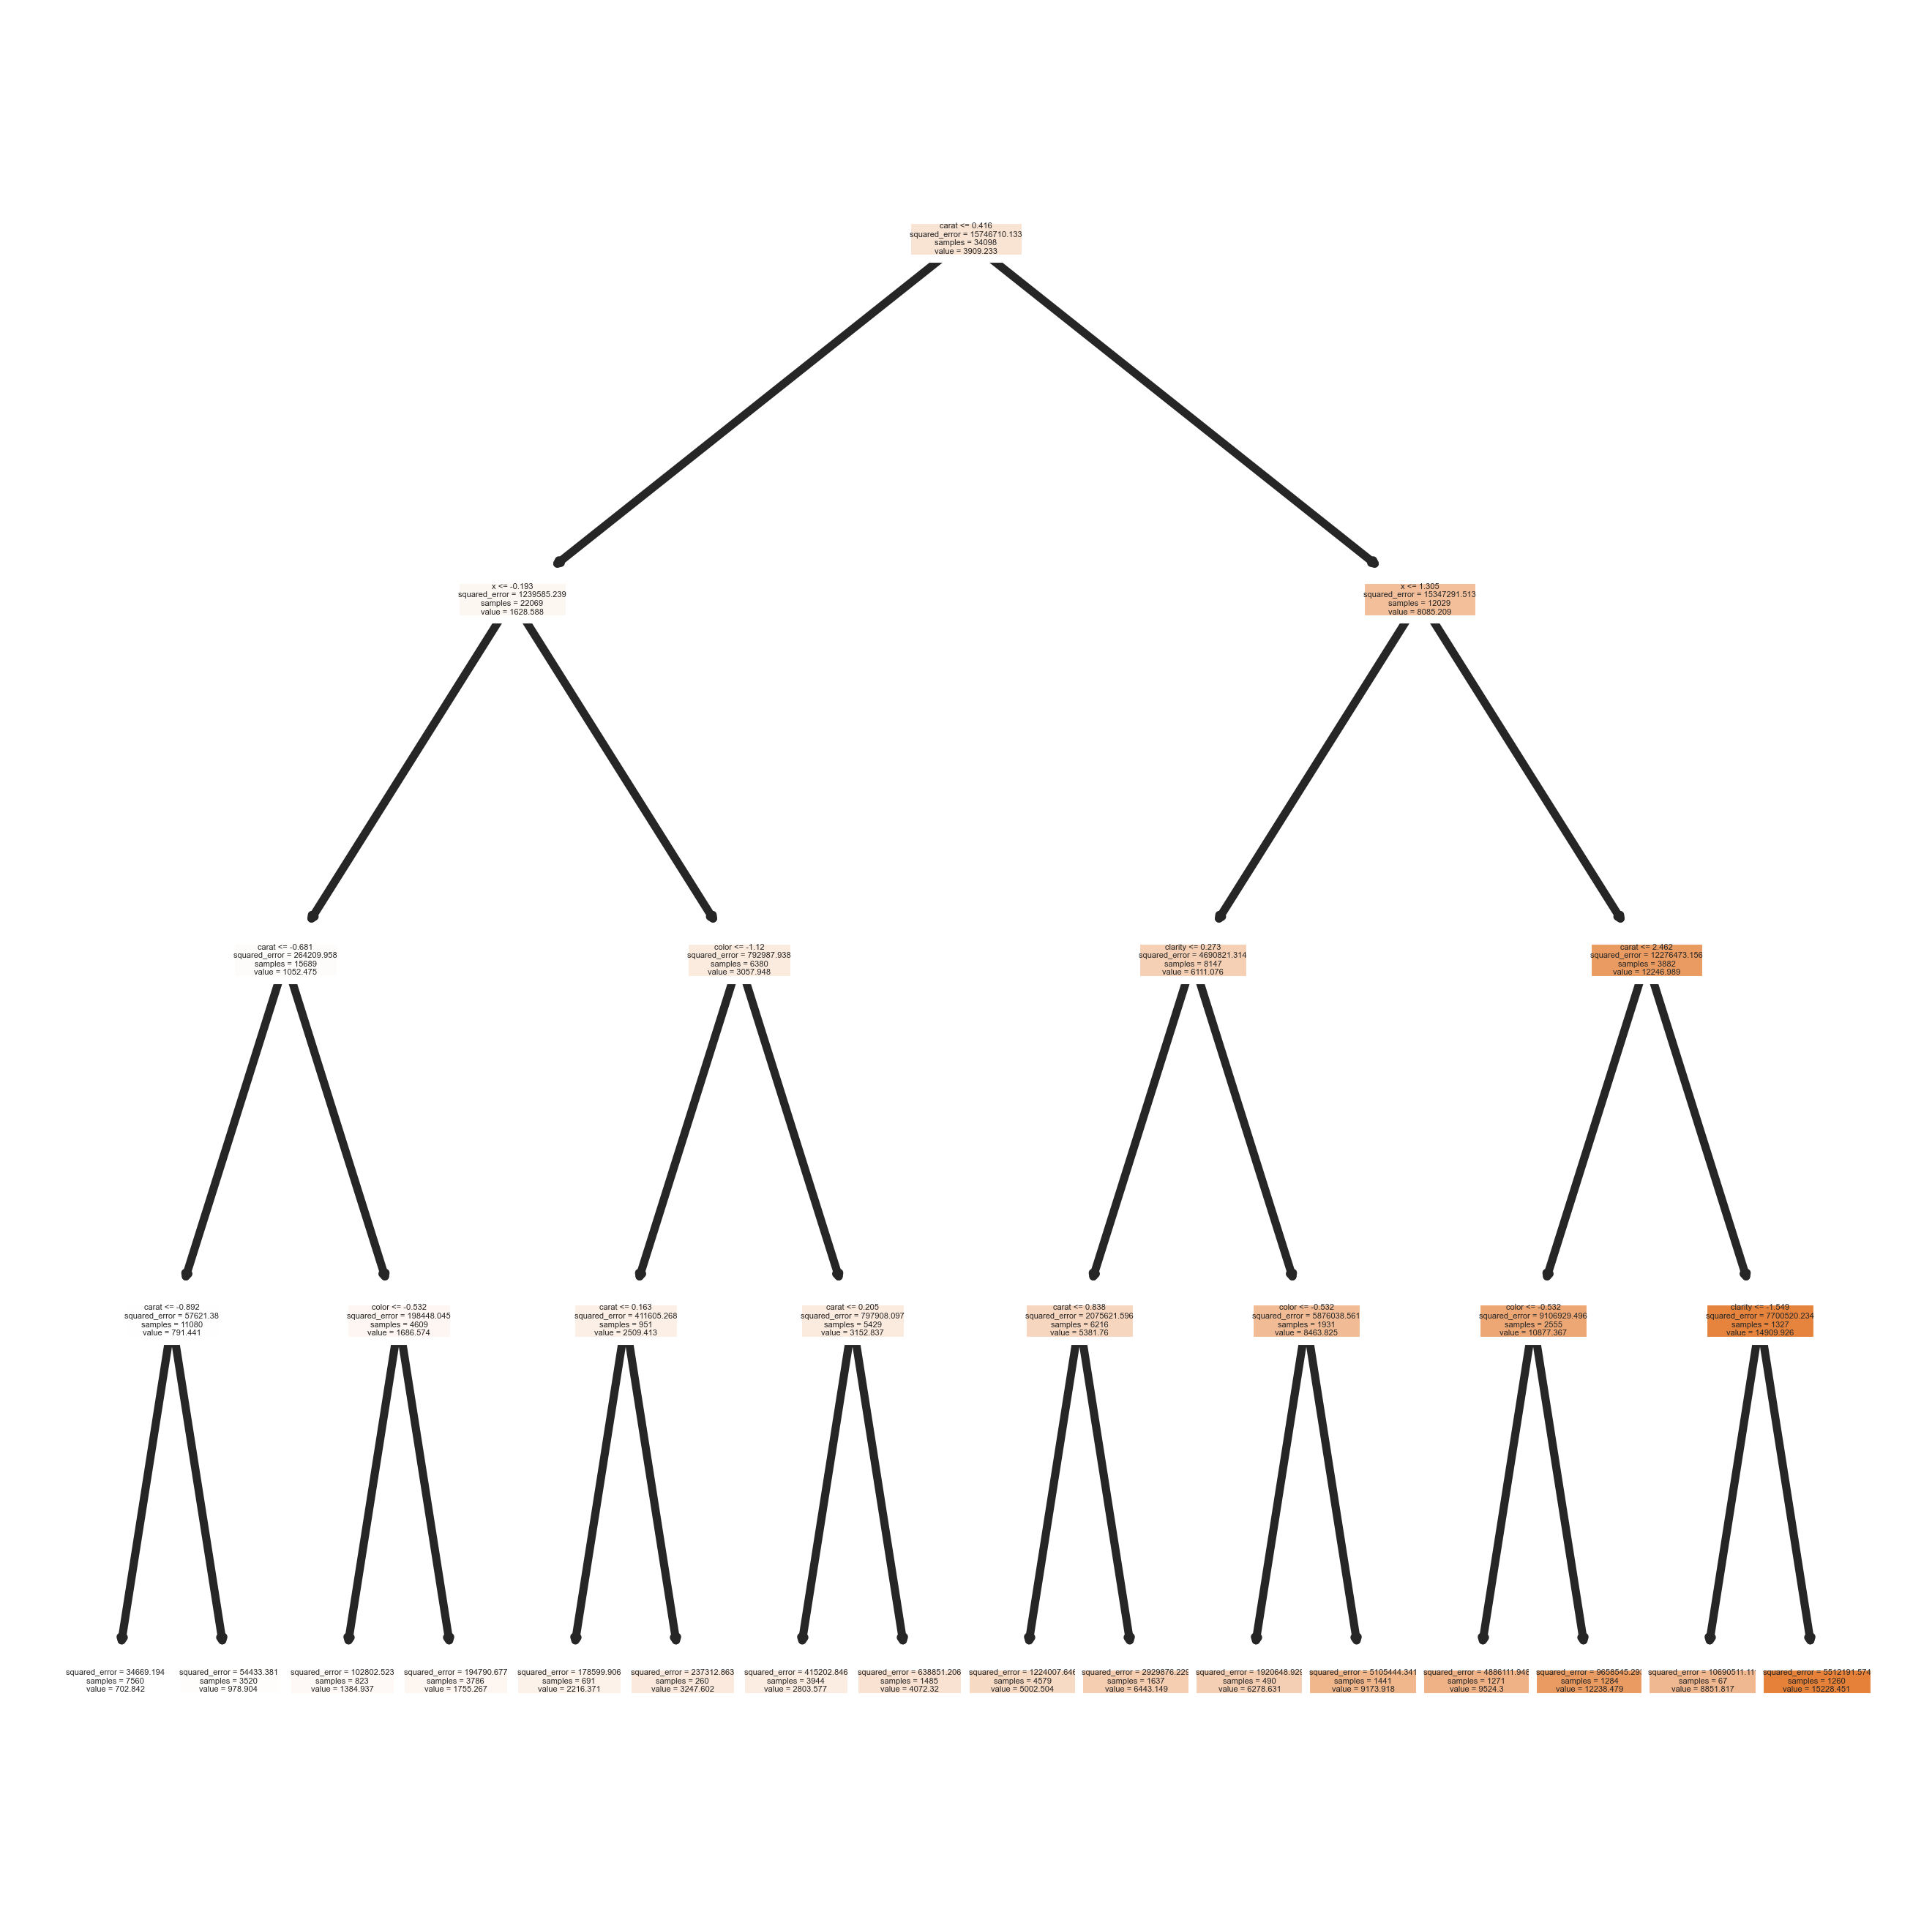

In [45]:
best_rf = grid_rf.best_estimator_
best_rf.fit(X, y)
fn = feat_cols
cn = targ_col
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi = 800)
tree.plot_tree(random.choice(best_rf.estimators_),
               feature_names = fn, 
               class_names = cn,
               filled = True)
plt.show()

The feature selected for branching at the root node is the x value. The importance of this feature is that it is the feature that offers the highest information gain, whether the x dimension is less than or equal to a specific value. This is inline with what we found with the mutual information and f-score.

Moreover, the results does match what we got in 3.3.1. As we can see the results from 3.3.1, x has the most negative coefficient.

## 7.4

In [51]:
from sklearn.metrics import r2_score

In [53]:
best_rf = grid_rf.best_estimator_
best_rf.fit(X, y)

df_rf = pd.DataFrame({"Best Random Forest":[best_rf.oob_score_, r2_score(y, best_rf.predict(X))]})
df_rf.index = ["OOB Score", "R^2 Score"]
df_rf

,Best Random Forest
OOB Score,0.923969
R^2 Score,0.925178


## Catboost

## 8.1

In [56]:
# !pip install catboost
# !pip install scikit-optimize
from catboost import CatBoostRegressor
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
from skopt.space import Real, Integer

Some important hyperparameters are the learning_rate, depth, l2_leaf_ref, and the n_estimators. 
- learning_rate: determines the step size at each iteration. A small search space is possibly between 0.01 and 0.2
- depth: the depth of the tree. A small search space is between 5 and 10
- l2_leaf_reg: coefficient at the L2 regularization term. A small search space is between 1 and 10
- n_estimators: the number of trees in the entire model. A small search space is possibly between 50 and 1000

## 8.2

In [72]:
X = df[feat_cols]
y = df[targ_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size = 0.75, 
                                                    test_size = 0.25, 
                                                    random_state = 0)

model = CatBoostRegressor(verbose = False)
search = {'learning_rate': Real(0.01, 0.2, prior = 'log-uniform'),
          'depth': Integer(5, 10),
          'l2_leaf_reg': Integer(1, 10),
          'n_estimators': Integer(50, 1000),
         }

opt = BayesSearchCV(estimator = model, 
                    search_spaces = search, 
                    scoring = "neg_mean_squared_error", 
                    n_jobs = -1,
                    n_iter = 50,
                    cv = 10,
                   )

opt.fit(X_train, y_train)
print("Best Parameters:", opt.best_params_)
print("Best RMSE:", np.sqrt(-1 * opt.best_score_))

Best Parameters: OrderedDict([('depth', 8), ('l2_leaf_reg', 7), ('learning_rate', 0.05724084038448387), ('n_estimators', 1000)])
Best RMSE: 533.4048519689828


## Question 8.3